In [11]:
import numpy as np
import pandas as pd 
from tensorflow import keras
import tensorflow as tf

# Res50Net by transfer learning

In [12]:
(x_train,y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [13]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [14]:
# preprocess data to use in Resnet50
def preproc(X,Y,leave_shape=True):
    if leave_shape:
        X_P = X
    else:
        X_P = tf.keras.applications.resnet50.preprocess_input(X)
    Y_P = tf.keras.utils.to_categorical(Y,10)
    return X_P,Y_P

In [15]:
x_train,y_train = preproc(x_train,y_train,leave_shape=False)
x_test, y_test = preproc(x_test, y_test,leave_shape=False)

In [16]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


In [17]:
tf.keras.backend.clear_session()
input_t = tf.keras.Input(shape=(32,32,3))
res_model = tf.keras.applications.ResNet50(include_top=False,
                                          weights="imagenet",
                                          input_tensor=input_t)

In [18]:
# freeze all layers exept last one
for layer in res_model.layers[:169]:
    layer.trainable =False
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name)

In [19]:

to_res = (32, 32)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
model.add(res_model)
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dense(256, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.5))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dense(128, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.5))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dense(64, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.5))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [20]:
model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
                  metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1,steps_per_epoch=400,
                    validation_data=(x_test, y_test))

Epoch 1/20
400/400 [==============================] - 125s 300ms/step - loss: 3.3226 - accuracy: 0.2520 - val_loss: 2.6245 - val_accuracy: 0.3431
Epoch 2/20
400/400 [==============================] - 119s 298ms/step - loss: 2.3494 - accuracy: 0.3838 - val_loss: 2.1484 - val_accuracy: 0.4216
Epoch 3/20
400/400 [==============================] - 117s 291ms/step - loss: 1.9999 - accuracy: 0.4441 - val_loss: 1.9224 - val_accuracy: 0.4647
Epoch 4/20
400/400 [==============================] - 121s 303ms/step - loss: 1.8720 - accuracy: 0.4749 - val_loss: 1.8013 - val_accuracy: 0.4917
Epoch 5/20
400/400 [==============================] - 120s 301ms/step - loss: 1.6691 - accuracy: 0.5095 - val_loss: 1.7093 - val_accuracy: 0.5074
Epoch 6/20
400/400 [==============================] - 110s 276ms/step - loss: 1.6080 - accuracy: 0.5217 - val_loss: 1.6424 - val_accuracy: 0.5188
Epoch 7/20
400/400 [==============================] - 114s 285ms/step - loss: 1.5515 - accuracy: 0.5396 - val_loss: 1.5859 -

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 1,076,234
Non-trainable params: 22,531,968
_________________________________________________________________


In [24]:
model.save_weights('cifar10_res50_net.h5', overwrite=True)

In [22]:
import matplotlib.pyplot as plt
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('ResNet50 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('ResNet50 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

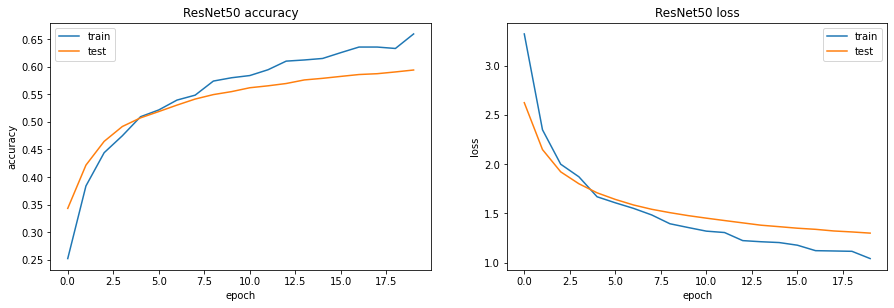

In [23]:
plot_accuracy_and_loss(history)

# SqueezeNet

In [15]:
(x_train,y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
x_train,y_train = preproc(x_train,y_train,leave_shape=True)
x_test, y_test = preproc(x_test, y_test,leave_shape=True)

In [72]:
def squeezeNet(input_shape, n_classes):
    def fire(x_in, n_squeeze, n_expand):
        x_sqeeze = tf.keras.layers.Conv2D(n_squeeze, 1, activation="relu")(x_in)
        x_expand1 = tf.keras.layers.Conv2D(n_expand, 1, activation="relu")(x_sqeeze)
        x_expand3 = tf.keras.layers.Conv2D(n_expand, 3, padding ="same", activation="relu")(x_sqeeze)
        output = tf.keras.layers.concatenate([x_expand1, x_expand3])
        return output
    inn = tf.keras.Input(input_shape) # size of your pictures
    x = tf.keras.layers.Conv2D(96, 7, strides=2, padding ="same", activation="relu")(inn)
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding ="same")(x)
    x = fire(x, 16, 64)
    x = fire(x, 16, 64)
    x = fire(x, 32, 128)
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding ="same")(x)
    x = fire(x, 32, 128)
    x = fire(x, 48, 192)
    x = fire(x, 48, 192)
    x = fire(x, 64, 256)
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding ="same")(x)
    x = fire(x, 64, 256)
    x = tf.keras.layers.Conv2D(n_classes, 1)(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    output = tf.keras.layers.Activation("softmax")(x)
    model = tf.keras.models.Model(inn, output)
    return model

In [73]:
tf.keras.backend.clear_session()
inshape = 32,32,3
nclasses = 10
model = squeezeNet(inshape, nclasses)
#model.summary()

In [74]:
model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                  metrics=['accuracy'])

In [75]:
history = model.fit(x_train, y_train, epochs=10, verbose=1,steps_per_epoch=400,
                    validation_data=(x_test, y_test), validation_steps=200)

Epoch 1/10
400/400 [==============================] - 163s 399ms/step - loss: 2.0143 - accuracy: 0.2497 - val_loss: 1.8533 - val_accuracy: 0.3258
Epoch 2/10
400/400 [==============================] - 158s 394ms/step - loss: 1.7699 - accuracy: 0.3483 - val_loss: 1.7572 - val_accuracy: 0.3664
Epoch 3/10
400/400 [==============================] - 155s 387ms/step - loss: 1.6478 - accuracy: 0.3958 - val_loss: 1.5550 - val_accuracy: 0.4288
Epoch 4/10
400/400 [==============================] - 163s 408ms/step - loss: 1.5536 - accuracy: 0.4310 - val_loss: 1.4464 - val_accuracy: 0.4728
Epoch 5/10
400/400 [==============================] - 178s 444ms/step - loss: 1.4809 - accuracy: 0.4617 - val_loss: 1.6159 - val_accuracy: 0.4283
Epoch 6/10
400/400 [==============================] - 162s 404ms/step - loss: 1.4202 - accuracy: 0.4828 - val_loss: 1.3386 - val_accuracy: 0.5167
Epoch 7/10
400/400 [==============================] - 159s 397ms/step - loss: 1.3617 - accuracy: 0.5040 - val_loss: 1.3184 -

In [81]:
import matplotlib.pyplot as plt
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

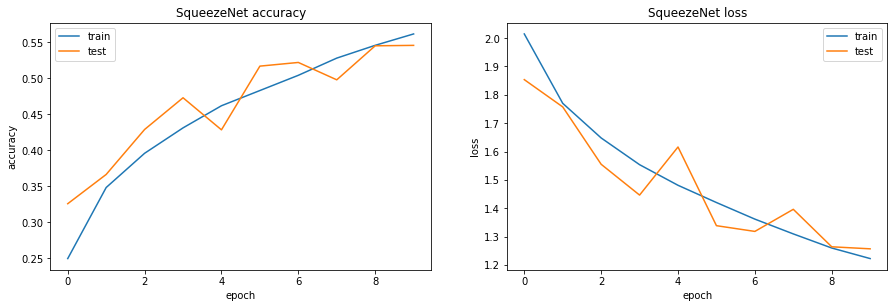

In [82]:
plot_accuracy_and_loss(history)

In [86]:
# save model's learned weights
#model.save_weights('cifar10_squeeze_net.h5', overwrite=True)
model.save('cifar10_squeeze_net')


INFO:tensorflow:Assets written to: cifar10_squeeze_net/assets


In [87]:
model = tf.keras.models.load_model('./cifar10_squeeze_net')